In [2]:
import statsmodels
import scipy
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportion_confint

In [3]:
%pylab inline
data = pd.read_csv('credit_card_default_analysis.csv')
data.head()

Populating the interactive namespace from numpy and matplotlib


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,0.356767,0.320033,0.304067,0.258767,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,0.760594,0.801727,0.790589,0.761113,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [5]:
n = data.ID.count()
data.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

#### Вспомогательные функции:

In [6]:
def plot_hist(data, category):
    data1 = data[data['default'] == 0][category].values
    data2 = data[data['default'] == 1][category].values
    pylab.figure()
    pylab.grid()
    pylab.hist(data1, color='r', label='default = 0')
    pylab.hist(data2, color='b', label='default = 1')
    pylab.xlabel(category)
    pylab.ylabel('Count')
    pylab.legend()
    pylab.show()
    
def plot_hist_categorical(data, category, labels):
    data1 = data[data['default'] == 0][category].values
    nbins = len(np.bincount(data1))
    data2 = data[data['default'] == 1][category].values
    
    pylab.figure()
    fig, ax = plt.subplots()
    pylab.grid()
    counts, bins, patches = ax.hist(data1, color='r', label='default = 0', bins=np.arange(nbins + 1))
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    for count, x in zip(counts, bin_centers):
        # Label the raw counts
        ax.annotate(str(count.astype(int32)), xy=(x, count), xycoords=('data'),
            xytext=(-14, 20), textcoords='offset points', va='top', ha='center')    
    
    counts, bins, patches = ax.hist(data2, color='b', label='default = 1', bins=np.arange(nbins + 1))
    for count, x in zip(counts, bin_centers):
        # Label the raw counts
        ax.annotate(str(count.astype(int32)), xy=(x, count), xycoords=('data'),
            xytext=(14, 14), textcoords='offset points', va='top', ha='center')    
        
    for count, x, l in zip(counts, bin_centers, labels):
        # Label the raw counts
        ax.annotate(l, xy=(x, 0), xycoords=('data'),
            xytext=(0, -18), textcoords='offset points', va='top', ha='center')    
    plt.subplots_adjust(bottom=0.15)
    ax.set_xticks(bins)
    ax.set_xlabel(category, labelpad=20)
    pylab.ylabel('Count')
    pylab.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pylab.show()

#### Z-критерий для разности долей (независимые выборки)

In [7]:
def proportions_diff_confint_ind(p1, p2, n1, n2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(p1, p2, n1, n2):
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

#### Bootstrap

In [97]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

#### Перестановочный критерий

In [99]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

#### Корреляция Мэтьюса

In [54]:
def matthews_coeff(a, b, c, d):
    return float(a*d - b*c) / (np.sqrt((a + b)*(a + c)*(b + d)*(c + d)))

### 1.Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

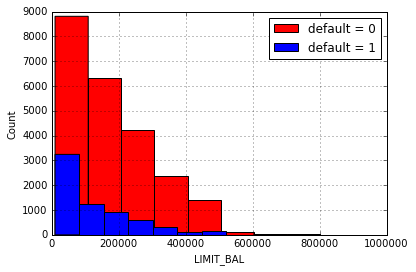

In [9]:
plot_hist(data, 'LIMIT_BAL')
def0_bal = data[data['default'] == 0].LIMIT_BAL.values
def1_bal = data[data['default'] == 1].LIMIT_BAL.values

По визуальной оценке графиков можно предположить, что медианные значения отличаются.

a)Проверим распределение выборок на нормальность. Построим Q-Q график.

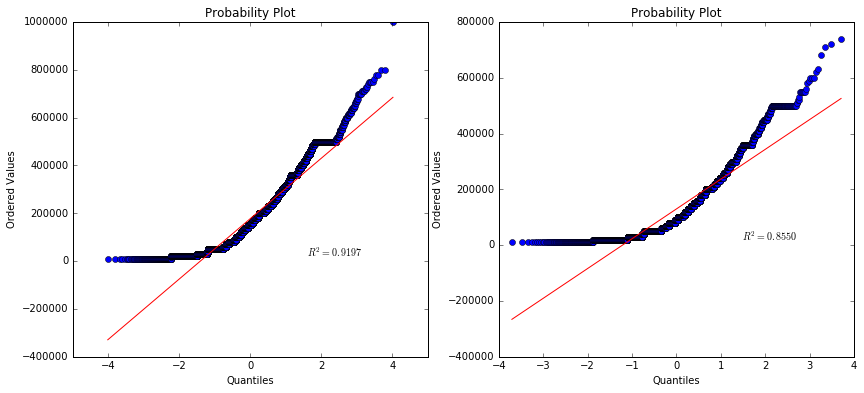

In [10]:
pylab.figure(figsize=(14,6))
pylab.subplot(121)
stats.probplot(def0_bal, dist = "norm", plot = pylab)

pylab.subplot(122)
stats.probplot(def1_bal, dist = "norm", plot = pylab)
pylab.show()

По графику распределение не похоже на нормальное, воспользуемся критерием Шапиро-Уилка:

$H_0\colon$ попарные разности распределены нормально.

$H_1\colon$ не нормально.

In [11]:
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %g" % stats.shapiro(def0_bal)
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %g" % stats.shapiro(def1_bal)

Shapiro-Wilk normality test, W-statistic: 0.919726, p-value: 0
Shapiro-Wilk normality test, W-statistic: 0.854983, p-value: 0


/home/evgenia/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:1329: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Поскольку распределение выборок не нормально, мы не можем воспользоваться t-интервалом. Построим доверительные интервала с помощью бутстрепа:

In [12]:
def0_bal_samples = map(np.median, get_bootstrap_samples(def0_bal, 1000))
def1_bal_samples = map(np.median, get_bootstrap_samples(def1_bal, 1000))

delta_median = map(lambda x: x[0] - x[1], zip(def0_bal_samples, def1_bal_samples))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median, 0.05)

95% confidence interval for the difference between medians [ 60000.  70000.]


95% доверительный интервал для разности медианных значений лежит полностью правее нуля, следовательно медианное значение кредитного лимита для выборки людей, вернувших кредит, больше медианы выборки невернувших.

In [105]:
data.LIMIT_BAL.value_counts()[:10]

50000     3365
20000     1976
30000     1610
80000     1567
200000    1528
150000    1110
100000    1048
180000     995
360000     881
60000      825
Name: LIMIT_BAL, dtype: int64

b)Поскольку в выборе много повторяющихся значение, ограничения для критерия Манна-Уитни не выполняются, воспользуемся перестановочным критерием для независимых выборок.

$$X_1^{n_1}=\left( X_{11}, ..., X_{1n_1}\right)$$
$$X_2^{n_2}=\left( X_{21}, ..., X_{2n_2}\right)$$

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

статистика: $$T\left( X_1^{n_1}, X_2^{n_2}\right) = \frac{1}{n_1} \sum_{i=1}^{n_1}{X_{1i}} - \frac{1}{n_2}\sum_{i=1}^{n_2}{X_{2i}} $$

In [107]:
print "p-value: %f" % permutation_test(def0_bal, def1_bal, max_permutations = 10000)

p-value: 0.000100


In [14]:
print "Difference between medians:", np.median(def0_bal) - np.median(def1_bal)

Difference between medians: 60000.0


p-value меньше 0.05, $H_0$ отвергается. Разница медиан - 60000 - статистически значима.
Полученный результат можно объяснить тем, что более надежным клиентам (вероятно, с хорошей кредитной историей) банк одобряет более высокий кредитный лимит. Они же чаще всего возвращают кредит. С другой стороны, человек, получивший изначально небольшой кредитный лимит и не вернувший его, вряд ли получит кредит в дальнейшем, тем более на более крупную сумму.
Результат можно считать скорее отражением политики банка нежели самостоятельным критерием для предсказания возврата кредита.

### 2.Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия) 

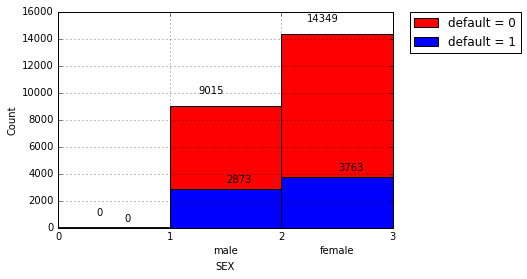

In [15]:
def0_sex = data[data['default'] == 0].SEX.values
def1_sex = data[data['default'] == 1].SEX.values

plot_hist_categorical(data, 'SEX', ['', 'male', 'female'])

Визуально гендерный состав среди вернувших и не вернувших кредит отличается.

a)Поскольку параметр пол принимает 2 значения, можно воспользоваться доверительным интервалом для доли. Построим доверительный интервал Уилсона для доли мужчин (sex=1) в обеих выборках:
$$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{
z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$$ 

In [16]:
wilson_interval0 = proportion_confint(len(np.where(def0_sex==1)[0]), len(def0_sex), method = 'wilson')
wilson_interval1 = proportion_confint(len(np.where(def1_sex==1)[0]), len(def1_sex), method = 'wilson')
print 'Default = 0: wilson_interval [%f, %f] with width %f' % (wilson_interval0[0],
                                                  wilson_interval0[1],
                                                  wilson_interval0[1] - wilson_interval0[0])
print 'Default = 1: wilson_interval [%f, %f] with width %f' % (wilson_interval1[0],
                                                  wilson_interval1[1],
                                                  wilson_interval1[1] - wilson_interval1[0])

Default = 0: wilson_interval [0.379627, 0.392110] with width 0.012483
Default = 1: wilson_interval [0.421062, 0.444898] with width 0.023836


Доверительные интервалы долей в обеих выборках не пересекаются, поэтому можно сделать вывод, что доля мужчин среди возвращающих кредит меньше, чем среди невозвращающих.

b)Воспользуемся z-критерием для доли для двух независимых выборок, $p_1$ - доля мужчин, вернувших кредит, $p_2$ - не вернувших:
$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$
$H_0: p_1 = p_2$

$H_1: p_1 \lt \ne \gt p_2$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [17]:
n1 = len(def0_sex)
n2 = len(def1_sex)
p1 = len(np.where(def0_sex==1)[0]) / float(n1)
p2 = len(np.where(def1_sex==1)[0]) / float(n2)

print "p-value: %g" % proportions_diff_z_test(proportions_diff_z_stat_ind(p1, p2, n1, n2))
print "Point difference between proportions: %f" % (p1 - p2)
print "95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(p1, p2, n1, n2)

p-value: 4.47287e-12
Point difference between proportions: -0.047092
95% confidence interval for a difference between proportions: [-0.060548, -0.033635]


p-value значительно меньше 0.05, поэтому можно отвергнуть гипотезу о равенстве долей мужчин в двух выборках. По доверительному интервалу видно, что доля мужчин среди возвращающих кредит меньше, чем среди невозвращающих. Точечная оценка разности долей $\approx 0.05$.
Практически такой результат не представляеся значимым, разница в долях мужчин слишком мала, чтобы основываться на этом параметре при принятии решения о выдаче кредита.

### 3. Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ? 

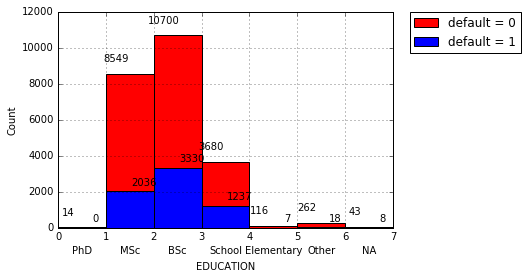

In [26]:
def_vals = {0:'default=0', 1:'default=1'}
ed_vals = {0:'PhD', 1:'MSc', 2:'BSc', 3:'School', 4:'Elementary', 5:'Other', 6:'NA'}
plot_hist_categorical(data, 'EDUCATION', labels=ed_labels)

Рассмотрим значимость корреляции признаков $X_1$ (default) и $X_2$ (education).
$$X_1 \in \{1,..,K_1\}, X_2 \in \{1,..,K_2\}$$,
где $K_1$ - множество значений переменной default, $K_2$ - множество значений переменной education, 

$H_0$: $X_1$ и $X_2$ независимы

$H_1$: $X_1$ и $X_2$ зависимы

Статистика: $$ \chi^2(X_1^n, X_2^n)=\sum_{i=1}^{K_1}\sum_{j=1}^{K_2}\frac{(n_{ij}-\frac{n_{i+}n_{+j}}{n})^2}{\frac{n_{i+}n_{+j}}{n}}=n \left( \sum_{i=1}^{K_1}\sum_{j=1}^{K_2}\frac{n_{ij}^2}{n_{i+}n_{+j}}-1 \right)$$

In [27]:
N1 = len(data.default.value_counts())
N2 = len(data.EDUCATION.value_counts())
actual = np.empty(shape=[N1, N2])
for k1 in np.unique(data.default.values):
    x = data[data['default'] == k1]
    for k2 in np.unique(data.EDUCATION.values):
        actual[k1, k2] = x[x.EDUCATION == k2].ID.count()
        
print actual.astype(int)

[[   14  8549 10700  3680   116   262    43]
 [    0  2036  3330  1237     7    18     8]]


Условия применимости критерия хи-квадрат выполняются: выборки независимы, выборка достаточно большая ($n \gt 40$), и ожидаемое количество элементов в каждой ячейке таблицы меньше 5, не более, чем в 20% ячеек (в 1 ячейке).

In [28]:
chi2, p, dof, expected = stats.chi2_contingency(actual)
print('p-value=%g') % (p)

p-value=1.23326e-32


p-value значительно меньше 0.05, поэтому нулевая гипотеза о независимости признаков отвергается. Рассчитаем коэффициент V Крамера:
$$ \phi_c(X_1^n, X_2^n) = \sqrt{\frac{\chi^2(X_1^n, X_2^n)}{n(min(K_1, K_2)-1)}}$$

In [79]:
phi = np.sqrt(chi2/float(n*(2 - 1)))
print 'Krammer coefficient = %f' % phi

Krammer coefficient = 0.030282


Таблица сопряженности "образование" на "возврат долга", значение ячейки - разность между наблюдаемым и ожидаемым количеством человек:

In [30]:
diffs = pd.DataFrame.from_records(actual - expected)
diffs.columns = ed_labels
diffs.rename(index={0: 'default=0', 1: 'default=1'}, inplace=True)
diffs

,PhD,MSc,BSc,School,Elementary,Other,NA
default=0,3.0968,305.402,-226.564,-149.3596,20.2076,43.936,3.2812
default=1,-3.0968,-305.402,226.564,149.3596,-20.2076,-43.936,-3.2812


Отмасштабируем таблицу, поделив на количество человек в каждой группе (по признаку default):

In [39]:
def_counts = data.default.value_counts()
counts = np.vstack(([def_counts[0]]*len(ed_vals), [def_counts[1]]*len(ed_vals)))
diffs_scaled = pd.DataFrame.from_records((actual - expected)/ counts)
diffs_scaled.columns = ed_vals.values()
diffs_scaled.rename(index=def_vals, inplace=True)
diffs_scaled

,PhD,MSc,BSc,School,Elementary,Other,NA
default=0,0.000133,0.013071,-0.009697,-0.006393,0.000865,0.001880,0.000140
default=1,-0.000467,-0.046022,0.034142,0.022507,-0.003045,-0.006621,-0.000494


Отобразим отмасштабированную разницу в ожидаемых и наблюдаемых значениях людей на графике:

<function matplotlib.pyplot.show>

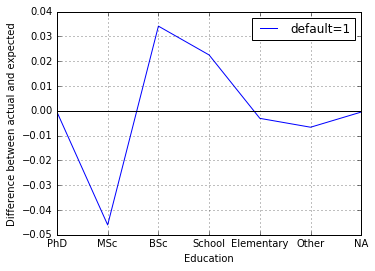

In [38]:
pylab.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(ed_vals.keys(), diffs_scaled.values[1], '-', label='default=1')
plt.plot([min(ed_vals.keys()),max(ed_vals.keys())], [0,0], '-', color='black')
plt.grid()
plt.xticks(ed_vals.keys(), ed_vals.values())
plt.xlabel('Education')
plt.ylabel('Difference between actual and expected')
plt.legend()
plt.show

По графику видно, что наилучшим индикатором того, что человек отдаст долг, является образование магистра (разница между ожидаемым и реальным количеством отрицательна). Наилучшим индикатором того, что человек НЕ отдаст долг, является образование бакалавра.

### 4. Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64


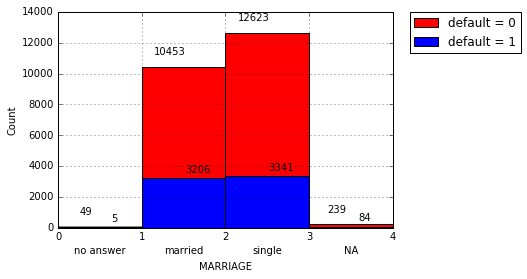

In [86]:
print data.MARRIAGE.value_counts()
mar_vals = dict({0:'no answer',1:'married', 2:'single',3:'NA'})
plot_hist_categorical(data, 'MARRIAGE', labels=mar_vals.values())

Значения 0 и 3 встречаются в выборке очень мало раз, к тому же неинформативны  (0 = отказываюсь отвечать; 3 = нет данных), поэтому исключим объекты с этими значениями для анализа влияния семейного положения на дефолт.

In [85]:
data_filtered = data.ix[data['MARRIAGE'].isin([1,2])]

Для оценки корреляции воспользуемся коэфффициентом Мэтьюса:

 X1/X2 | Married | Single
  ------------- | -------------|
   **default=0**  | a | b 
  **default=1** | c  | d

In [75]:
a = len(data_filtered.ix[(data_filtered['default'] == 0) & (data_filtered['MARRIAGE'] == 1)].values)
b = len(data_filtered.ix[(data_filtered['default'] == 0) & (data_filtered['MARRIAGE'] == 2)].values)
c = len(data_filtered.ix[(data_filtered['default'] == 1) & (data_filtered['MARRIAGE'] == 1)].values)
d = len(data_filtered.ix[(data_filtered['default'] == 1) & (data_filtered['MARRIAGE'] == 2)].values)
print 'a=%i \t b=%i \n c=%i \t d=%i' % (a, b, c, d)
mcc = matthews_coeff(a, b, c, d)
print 'Matthews coefficient MCC = %f' % mcc

a=10453 	 b=12623 
 c=3206 	 d=3341
Matthews coefficient MCC= -0.030555


Значение коэффициента Мэтьюса говорит об отрицательной корреляции, то есть для неженатых людей вероятность дефолта меньше. Оценим уровень значимости корреляции с помощью критерия хи-квадрат. Условия применимости критерия хи-квадрат выполняются: выборки независимы, выборка достаточно большая ($n \gt 40$), и ожидаемое количество элементов в каждой ячейке таблицы меньше 5, не более, чем в 20% ячеек (все больше).

$$H_0: MCC = 0$$
$$H_1: MCC \ne 0$$

статистика: $\chi^2=nMCC^2$

In [80]:
chi2, p, dof, ex = stats.chi2_contingency(np.array([[a, b],[c, d]]))
print 'p-value=%g' % p

p-value=1.56332e-07


p-value меньше 0.05, поэтому нулевая гипотеза отвергается: между признаками семейное положение и дефолт есть отрицательная корреляция.

### 5. Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

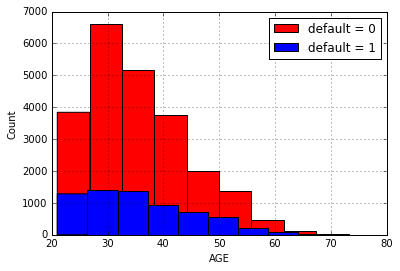

In [89]:
plot_hist(data, 'AGE')

In [93]:
def0_age = data[data['default'] == 0].AGE.values
def1_age = data[data['default'] == 1].AGE.values

Проверим данные о возрасте на нормальность критерием Шапиро-Уилка:

$H_0\colon$ данные распределены нормально.

$H_1\colon$ не нормально.

In [95]:
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %g" % stats.shapiro(def0_age)
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %g" % stats.shapiro(def1_age)

Shapiro-Wilk normality test, W-statistic: 0.949614, p-value: 0
Shapiro-Wilk normality test, W-statistic: 0.950164, p-value: 1.07339e-42


Данные распределены не нормально. Построим доверительные интервала с помощью бутстрепа:

In [102]:
def0_age_samples = map(np.median, get_bootstrap_samples(def0_age, 1000))
def1_age_samples = map(np.median, get_bootstrap_samples(def1_age, 1000))

delta_median = map(lambda x: x[0] - x[1], zip(def0_age_samples, def1_age_samples))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median, 0.05)
print "Point estimate for the difference between medians ", np.median(def0_age) - np.median(def1_age)

95% confidence interval for the difference between medians [-1.  0.]
Point estimate for the difference between medians  0.0


Доверительный интервал включает 0, поэтому нельзя с уверенностью сказать, что медианы отличаются.
Воспользуемся перестановочным критерием для независимых выборок. 
$$X_1^{n_1}=\left( X_{11}, ..., X_{1n_1}\right)$$
$$X_2^{n_2}=\left( X_{21}, ..., X_{2n_2}\right)$$

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

статистика: $$T\left( X_1^{n_1}, X_2^{n_2}\right) = \frac{1}{n_1} \sum_{i=1}^{n_1}{X_{1i}} - \frac{1}{n_2}\sum_{i=1}^{n_2}{X_{2i}} $$

In [108]:
print "p-value: %f" % permutation_test(def0_age, def1_age, max_permutations = 10000)

p-value: 0.016200


Значение p-value меньше 0.05, поэтому нулевая гипотеза отвергается: между распределениями есть сдвиг, значит средние отличаются статистически значимо. Доверительный интервал для разницы средних $[-1, 0]$, такая разница в возрастах не имеет практической значимости.